In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

images_path = Path('data/images')
anno_path = Path('data/annotations')

## Распарсим аннотации и соберем всё в датафрейм

In [3]:
from save_load_files import parse_annotation
df = parse_annotation(anno_path, images_path)
class_dict = {'cat': 0, 'dog': 1}
df['class'] = df['class'].apply(lambda x:  class_dict[x])

In [4]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,data/images/Cats_Test0.png,233,350,0,83,29,197,142
1,data/images/Cats_Test1.png,500,500,1,128,22,240,222
2,data/images/Cats_Test10.png,500,375,1,157,56,264,116
3,data/images/Cats_Test100.png,500,375,0,142,145,206,209
4,data/images/Cats_Test1000.png,335,500,0,36,14,289,312
...,...,...,...,...,...,...,...,...
3681,data/images/Cats_Test995.png,500,375,1,98,46,179,134
3682,data/images/Cats_Test996.png,500,335,0,375,53,458,134
3683,data/images/Cats_Test997.png,500,333,0,192,88,310,212
3684,data/images/Cats_Test998.png,375,500,0,145,37,257,165


## Меняем размер изображений и соответсвенно корректируем bb.

In [5]:
%%time
from resize_images import resize_image_bb, create_bb_array
import os

new_paths = []
new_bbs = []
train_path_resized = Path('data/resized')
isExist = os.path.exists(train_path_resized)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(train_path_resized)
    
    
for index, row in df.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df['new_path'] = new_paths
df['new_bb'] = new_bbs

CPU times: user 1min 18s, sys: 33.9 s, total: 1min 52s
Wall time: 3min 34s


In [6]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,data/images/Cats_Test0.png,233,350,0,83,29,197,142,data/resized/Cats_Test0.png,"[24.0, 158.0, 121.0, 378.0]"
1,data/images/Cats_Test1.png,500,500,1,128,22,240,222,data/resized/Cats_Test1.png,"[13.0, 114.0, 132.0, 214.0]"
2,data/images/Cats_Test10.png,500,375,1,157,56,264,116,data/resized/Cats_Test10.png,"[44.0, 140.0, 92.0, 235.0]"
3,data/images/Cats_Test100.png,500,375,0,142,145,206,209,data/resized/Cats_Test100.png,"[116.0, 127.0, 167.0, 184.0]"
4,data/images/Cats_Test1000.png,335,500,0,36,14,289,312,data/resized/Cats_Test1000.png,"[8.0, 47.0, 186.0, 385.0]"
...,...,...,...,...,...,...,...,...,...,...
3681,data/images/Cats_Test995.png,500,375,1,98,46,179,134,data/resized/Cats_Test995.png,"[36.0, 87.0, 107.0, 159.0]"
3682,data/images/Cats_Test996.png,500,335,0,375,53,458,134,data/resized/Cats_Test996.png,"[47.0, 335.0, 119.0, 409.0]"
3683,data/images/Cats_Test997.png,500,333,0,192,88,310,212,data/resized/Cats_Test997.png,"[79.0, 171.0, 190.0, 277.0]"
3684,data/images/Cats_Test998.png,375,500,0,145,37,257,165,data/resized/Cats_Test998.png,"[22.0, 172.0, 98.0, 306.0]"


<Figure size 640x480 with 0 Axes>

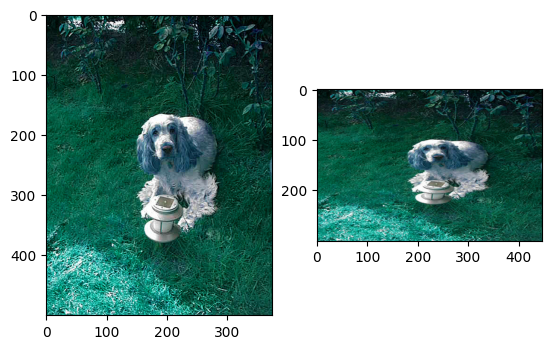

In [7]:
import cv2
import matplotlib.pyplot as plt

im1 = cv2.imread(str(df.values[59][0]))
im2 = cv2.imread(str(df.values[59][8]))
plt.figure()
f, axarr = plt.subplots(1,2)

axarr[0].imshow(im1)
axarr[1].imshow(im2)

## Разделим выборку на обучающую и отложенную и сохраним

In [8]:
from sklearn.model_selection import train_test_split

df = df.reset_index()
X = df[['new_path', 'new_bb']]
Y = df['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
X_train.to_pickle("data/x_train.pkl")
X_val.to_pickle("data/x_val.pkl")
y_train.to_pickle("data/y_train.pkl")
y_val.to_pickle("data/y_val.pkl")

## Train будем использовать в модуле 2_modeling а eval в модуле 3_evaluation